In [10]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/brown/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Importing Tweet Data
***

In [5]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [6]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [7]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [8]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [11]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [12]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

'This is some     text that has   char  in it'

In [13]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

'This is some  textthat has char in it'

In [10]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [14]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [15]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

## Word/Token Statistics
***

In [16]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [17]:
word_counts.size

43387

In [18]:
word_counts.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
           2463
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
dtype: int64

In [19]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [20]:
word_counts_reduce.size

43254

In [21]:
np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

array(['', '#Airborn....', '#AllRise....', '#Duuuuuvaaaaaal',
       '#Honeyyyyyyyyy', '#JusticeRainsFraaahhhhhhhh', '#Miami.....',
       '#OhFlorida....', '#ahhhhhhhh', '....', '.....', '......',
       '.........', '..........................................',
       '...........also', '........not', '.......ruffing', '.....I',
       '.....i', '.....who', '....6pm', '....Christ', '....IM',
       '....Sending', '....TCB', '....dont', '....prayers', '....ready',
       '....real', '....so', '...soooo...NOT', '0-1....', '10000',
       '100000', '1000000', '111st...WESTSIDE...smdh....', '333333',
       '3am......', '77.......', '@KingCartaaaaa', '@PrettyBieberrrr',
       '@_Eric____', '@__Poodaaaa', '@bbvanillaaaaa', '@brianabanksxxxx',
       '@brimiiiii', '@natalaaaayyyy', 'AHHHHHHHHH', 'ALLLL', 'Aaaaaand',
       'Aaaaand', 'Aaaaannnnnd', 'Aawwww', 'Aghhhhhhhh', 'Ahhhh',
       'Ahhhhh', 'Amazing....This', 'America....tune',
       'And......here......we........go', 'Andddd', 'A

In [22]:
word_counts_reduce.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
at         1129
dtype: int64

In [ ]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [ ]:
# word_counts_full_tokenizer.size

In [ ]:
# word_counts_full_tokenizer.head(20)

In [26]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [ ]:
# tweet_test = tweet_text.loc['2017-09-10 00:03:40'][1]
# print(tweet_test)
# tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
# print(tweet_test.split())
# i=0
# print(f"S: {tweet_test}");i+=1
# #     1: remove URLs:
# tweet_test = re.sub('https?://\S+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     2: remove @mentions, including those with a leading '-' or '.' : 
# tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     3: remove punctuation, but not hashtags:
# tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
# print(f"{i}: {tweet_test}");i+=1
# #     4: remove non-hashtag '#'.
# # tweet_test = re.sub('#\B','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# # tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     6: drop words of < 4 characters, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     7: drop numbers, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

In [27]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That...
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://...
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedi, product, kill, virus, fungal,...
2017-09-10 00:03:40                         [tag, #1, us, biscayn, blvd]
Name: tweet_text, dtype: object


In [28]:
tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

Series([], Name: tweet_text, dtype: object)

In [29]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [30]:
word_counts_full_token_clean.size

14439

In [31]:
word_counts_full_token_clean.head(20)

florida           1809
#hurricaneirma    1623
fl                1587
irma              1374
hurrican          1360
#irma             1193
wind               946
get                936
report             886
go                 830
storm              775
power              715
miami              705
rain               682
mph                661
like               657
beach              656
gust               655
safe               633
aso                544
dtype: int64

In [32]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [33]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [34]:
tweet_len_post[tweet_len_post.index <= 10].sum()

15971

In [35]:
tweet_len_post.sum()

19089

In [36]:
tweet_len

tweet_text
1       37
2      342
3      622
4      753
5      815
6      911
7      956
8     1052
9     1121
10    1022
11    1020
12    1040
13     988
14    1005
15    1308
16    1112
17     876
18     862
19     736
20     587
21     493
22     349
23     317
24     239
25     151
26     163
27      70
28      68
29      33
30      21
31      12
32       6
33       2
Name: tweet_text, dtype: int64

In [37]:
tweet_len_post

0       91
1      874
2     1402
3     1565
4     1745
5     1854
6     1800
7     1812
8     1865
9     1684
10    1279
11    1278
12     870
13     526
14     206
15     117
16      73
17      26
18      14
19       6
20       2
Name: tweet_text, dtype: int64

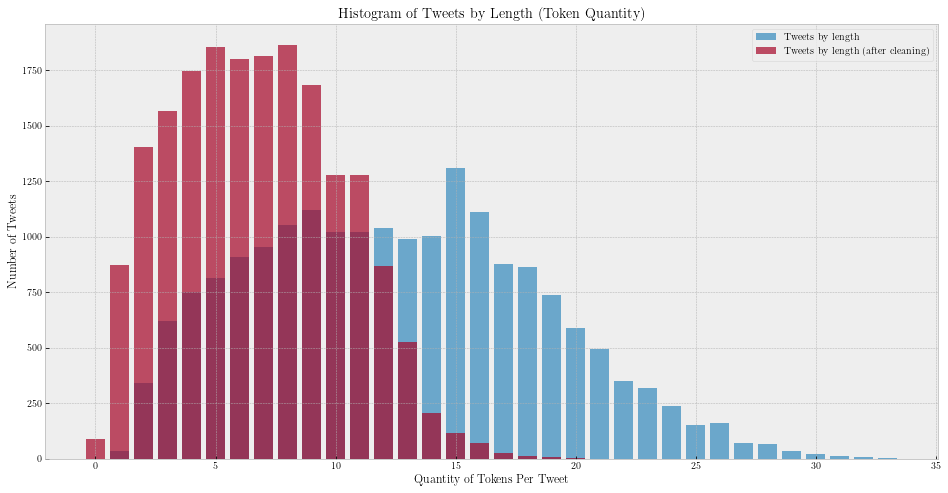

In [38]:
fig_tweet_hist = plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
# fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [39]:
search_term = 'irma'

### Window Size: 1-10

In [40]:
# comparison_type = "Min. Word Freq."
# comparison_short = "MinWordFreq"
comparison_type = "Window Size"
comparison_short = "WindowSize"

In [41]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [42]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(1,11):
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=i, workers=1, size=100, seed=1)#, sg=1, hs=1)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Network Graphs

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# ---------- Skip-Gram ----------
# initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
vector_model = Word2Vec(tweets_tokens, min_count=1, window=5, workers=1, size=100, seed=1, sg=1, negative=1)

# train the model over 10 epochs
vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

# assign the vector data to its position in a series
# vectors_series.iloc[i] = vector_model

(1181600, 1289640)

In [ ]:
len(vector_model.wv.vocab) == word_counts_full_token_clean.size

True

In [ ]:
set(word_counts_full_token_clean.index) == set(vector_model.wv.vocab.keys())

True

In [ ]:
list(vector_model.wv.vocab.keys())

['wind',
 'mph',
 'n',
 'baromet',
 'steadi',
 'temperatur',
 'f',
 'rain',
 'today',
 'humid',
 'alway',
 'beauti',
 'regardless',
 'circumst',
 'palm',
 'coast',
 'florida',
 '#carpool',
 '#orlando',
 '#kirkmanroad',
 'rideshar',
 'split',
 'cost',
 'take',
 'turn',
 'nah',
 'chillin',
 'eye',
 'never',
 'get',
 'red',
 'feel',
 'bout',
 'seein',
 'travi',
 'beak',
 'board',
 'window',
 'kitti',
 'pettin',
 'temp',
 'hum',
 'dewp',
 'bar',
 'hpa',
 'inch',
 'kn',
 'proud',
 'local',
 'radio',
 'news',
 'anim',
 'shelter',
 'peopl',
 'bad',
 'much',
 'good',
 '#irmahurricane2017',
 'even',
 'hurrican',
 '#hurrican',
 '#hurricaneirma',
 '#sunset',
 '#tampa',
 '#florida',
 '#weather',
 '#storm',
 'hey',
 'big',
 'head',
 'deplor',
 'nation',
 'pleas',
 'pray',
 'us',
 'difficult',
 'situat',
 'lot',
 'poor',
 'noth',
 'light',
 'water',
 'ever',
 'want',
 'lol',
 'game',
 'put',
 'swimsuit',
 'go',
 'outsid',
 'lightn',
 'bore',
 'af',
 'look',
 'like',
 'fine',
 'kissimme',
 'safe',
 '

In [ ]:
for i in word_counts_full_token_clean.iteritems():
    print(i[1])

1809
1623
1587
1374
1360
1193
946
936
886
830
775
715
705
682
661
657
656
655
633
544
510
510
506
498
494
437
436
426
415
402
395
386
373
370
366
366
362
357
347
345
340
324
320
318
316
312
311
311
308
306
305
301
300
298
283
281
280
272
271
269
267
266
265
260
257
255
254
251
248
247
240
240
239
239
235
235
234
233
232
227
226
219
219
218
217
214
212
212
212
212
210
208
207
205
204
202
201
201
200
200
197
195
194
194
194
191
190
188
187
187
186
181
180
179
174
173
173
173
172
170
169
166
166
165
164
163
161
161
160
158
158
157
156
156
156
155
155
154
151
151
150
150
150
148
147
147
143
143
142
142
141
140
140
140
139
139
138
137
136
135
134
133
132
132
132
131
131
131
129
128
127
127
125
125
125
125
123
123
123
123
123
122
122
121
121
121
121
121
120
119
119
119
118
117
117
116
116
115
115
115
114
112
110
110
110
110
109
109
108
108
107
107
106
106
106
106
106
105
105
105
103
103
103
103
102
102
102
101
101
100
100
100
99
99
98
98
98
97
96
95
95
94
94
93
93
93
92
92
92
92
92
92
91
90


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
import networkx as nx
from itertools import combinations
word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
tweet_graph = nx.Graph()
tweet_graph.add_nodes_from(word_counts_full_token_clean.iteritems())
for pair in word_pairs:
    edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
    tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
        
       
        
nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
tweet_graph.nodes

### Comparison Functions

In [ ]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [ ]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [ ]:
func_type = "Dot Product of Tweet Vector and Search Term"
func_short = "DotProduct"
def ScoreTweetFromVectors(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [ ]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [ ]:
tweet_encoded.iloc[0:5].tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[1],))

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_0 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or above Threshold")
plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

In [ ]:
fig_1 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [ ]:
comparison_type = "Hidden Layer Dimensionality"
comparison_short = "HLD"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(1,11):
    hidden_layer_dim = 25*i + 25
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=hidden_layer_dim, seed=1, sg=1)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

In [ ]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    window_label = f"{comparison_type}: {25*i + 25}"
    plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_hld_2.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [ ]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')